In [1]:
# TODO
# Import/read ATL11 (try h5coro)
# Add ATL11 overlay

# Add something along the lines of code below to illustrate lake area/outline:
# # Plot polygons in the GeoDataFrame
# gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1, label='Polygon Area')
# # Optionally, if you want to plot just the boundaries with a different style
# gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Polygon Boundary')

# Simplify subsetting code:
# CS2_dh_sub = CS2_dh.sel(y=slice(y_max, y_min), x=slice(x_min, x_max))
# ATL15_dh_sub = ATL15_dh.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

# Simplify codes to makes lines:
# Creating custom legend entries as lines
    # line_3_1 = mlines.Line2D([], [], color='red', linewidth=2, label='v3.1')
    # line_3_6 = mlines.Line2D([], [], color='blue', linewidth=2, label='v3.6')

In [2]:
# Code to Fig. S1 of Sauthoff and others, 2024
# This code runs continental-scale operations on multiple datasets and
# requires a 128 GB server or local memory
#
# Written 2023-07-11 by W. Sauthoff (wsauthoff.github.io)

# Set up computing environment

In [3]:
%pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import libraries
import datetime
import earthaccess
import gc
import geopandas as gpd
from IPython.display import clear_output
import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
from os import path
import pandas as pd
from pyproj import CRS, Geod, Transformer
import rioxarray
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import box, Point, Polygon
from shapely.ops import unary_union
from skimage import measure
import time
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

from IPython.display import Audio, display
def play_sound():
    display(Audio(url="http://codeskulptor-demos.commondatastorage.googleapis.com/pang/pop.mp3", autoplay=True))

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer

# Change default font to increase font size
plt.rcParams.update({'font.size': 8})

# Create a Geod object for calculating area on the WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Functions

In [5]:
# def read_field(group, field):
#     """
#     generic field-reading function
#     """
#     data=np.array(group[field])
#     bad=(data==group[field].attrs['_FillValue'])
#     data[bad]=np.NaN
#     return data

In [6]:
# def read_ATL11(filename, pair):
#     """
#     ATL11 reader
#     """
#     with h5py.File(filename,'r') as h5f:
#         longitude=read_field(h5f[pair],'longitude')
#         latitude=read_field(h5f[pair],'latitude')
#         h_corr=read_field(h5f[pair],'h_corr')
#         h_corr_sigma=read_field(h5f[pair],'h_corr_sigma')
#         h_corr_sigma_s=read_field(h5f[pair],'h_corr_sigma_systematic')
#         quality=np.array(h5f[pair]['quality_summary'])
#     for col in range(h_corr.shape[1]):
#         h_corr[quality==1]=np.NaN
#     # return the values
#     return longitude, latitude, h_corr, np.sqrt(h_corr_sigma**2+h_corr_sigma_s**2)

In [7]:
def datetime64_to_fractional_year(date):
    """
    Convert a numpy.datetime64 object into a fractional year, rounded to 0, .25, .5, or .75.
    """
    year = date.astype('datetime64[Y]').astype(int) + 1970
    start_of_year = np.datetime64(f'{year}-01-01')
    start_of_next_year = np.datetime64(f'{year + 1}-01-01')
    year_length = (start_of_next_year - start_of_year).astype('timedelta64[D]').astype(int)
    day_of_year = (date - start_of_year).astype('timedelta64[D]').astype(int)
    fractional_year = year + day_of_year / year_length

    # Round to nearest quarter
    rounded_fractional_year = round(fractional_year * 4) / 4
    return rounded_fractional_year

# # Example usage
# date = np.datetime64('2024-01-05')
# fractional_year = datetime64_to_fractional_year(date)

In [8]:
def muliple_area_buffer(polygon, area_multiple, precision=100):
    """
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    :param polygon: Shapely Polygon object
    :param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    :param precision: Precision for the iterative process to find the buffer distance
    :return: Buffered Polygon
    """
    original_area = polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    buffered_polygon = polygon

    while True:
        buffered_polygon = polygon.buffer(buffer_distance)
        if buffered_polygon.area >= target_area:
            break
        buffer_distance += precision
    
    # Convert to geodataframe
    buffered_polygon_gdf = gpd.GeoDataFrame({'geometry': [buffered_polygon]})
    
#     # Set CRS
#     buffered_polygon_gdf.geometry.crs = 'EPSG:3031'

#     return buffered_polygon_gdf
    return buffered_polygon

# # Example usage
# # Define a simple square polygon
# square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])

# # Apply the function to find the buffered polygon area and bounds
# buffered_poly = double_area_buffer(square)
# buffered_poly.area, buffered_poly.bounds

In [9]:
def create_folder(directory):
    # Check if the directory already exists
    if not os.path.exists(directory):
        # If it doesn't exist, create a new directory
        os.makedirs(directory)
        print(f"Folder '{directory}' created successfully.")
    else:
        print(f"Folder '{directory}' already exists.")

In [10]:
def plot_data_counts(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of counts going into gridded ice-surface height change (dh/dt) products
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs:
    * Sequence of planview data count visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    
    # # Create buffered polygons for various multiples of lake area to find which
    # # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = muliple_area_buffer(lake_poly, 10)
    
    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer = abs(x_max-x_min)*0.5
    y_buffer = abs(y_max-y_min)*0.5

    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_data_counts'))
    create_folder(OUTPUT_DIR + '/plot_data_counts/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    lakes_gdf_notSF18_color = 'darkturquoise'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_gdf_notSF18_line = plt.Line2D((0, 1), (0, 0), color=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent_line = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            count_subset = dataset1_subset['data_count'][idx,:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            count_subset = dataset2_subset['data_count'][(idx-33),:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)
            
        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(count_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(count_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
                origin='lower', cmap='viridis')

            # Plot buffered polygons
            gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=2)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
            SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
            lakes_gdf_notSF18.boundary.plot(ax=ax, edgecolor=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

            # Plot inset map
            axIns = ax.inset_axes([0.01, 0.01, 0.2, 0.2]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('data counts', size=15)

            # Add legend
            ax.legend([Smith2009, 
                       SiegfriedFricker2018, 
                       lakes_gdf_notSF18_line,
                       search_extent_line                       
                      ],
                ['static outline (S09)', 
                 'static outline (SF18)', 
                 'other',
                 'search extent'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Data counts from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_data_counts/{}/plot_data_counts_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [11]:
def plot_height_changes(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of ice surface height changes (dh/dt)
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = muliple_area_buffer(lake_poly, 10)

    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
    
    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    # Create empty lists to store data
    height_anom_pos = []
    height_anom_neg = []
    for idx in range(len(midcyc_dates)):
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
        if np.any(~np.isnan(dhdt_subset)):       
            pos = np.nanmax(dhdt_subset)
            neg = np.nanmin(dhdt_subset)
            height_anom_pos += [pos]
            height_anom_neg += [neg]
    
    # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    
    # Establish diverging colorbar
    divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
   
    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_height_changes'))
    create_folder(OUTPUT_DIR + '/plot_height_changes/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    lakes_gdf_notSF18_color = 'darkturquoise'
    # S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    S09_line = plt.Line2D([], [], color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_gdf_notSF18_line = plt.Line2D((0, 1), (0, 0), color=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent_line = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to reset idx to zero for new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer],
                origin='lower', cmap='coolwarm_r', 
                norm=divnorm)

            # Plot buffered polygons
            gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
            SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
            lakes_gdf_notSF18.boundary.plot(ax=ax, edgecolor=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

            # Plot inset map
            axIns = ax.inset_axes([0.01, 0.01, 0.2, 0.2]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([S09_line, 
                       SF18_line, 
                       lakes_gdf_notSF18_line,
                       search_extent_line
                      ],
                ['static outline (S09)', 
                 'static outline (SF18)', 
                 'other',
                 'search extent'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Height change from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_height_changes/{}/plot_height_changes_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [12]:
def find_evolving_outlines(lake_gdf, area_multiple_search_extent, level, dataset1, dataset2, plot=False): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs:
    * ROI_name: str of the region of interest for using in file name saving
    * ROI_poly: list of polygon(s) that define evolving outline search extent
    * level: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    buffered_gdf = muliple_area_buffer(lake_poly, area_multiple_search_extent+1)
    
    # Clipping datasets
    if dataset1 != 'none':
        dataset1_clipped = dataset1.rio.clip(buffered_gdf.geometry, dataset1.rio.crs)
    dataset2_clipped = dataset2.rio.clip(buffered_gdf.geometry, dataset2.rio.crs)
    
    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_gdf.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
   
    # Only proceed with plotting if plot=True
    if plot:
        # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
        # Create empty lists to store data
        height_anom_pos = []
        height_anom_neg = []
        for idx in range(len(midcyc_dates)):
            if idx <= 32:
                if dataset1 != 'none':
                    dhdt_clipped = dataset1_clipped.delta_h[idx+1,:,:]-dataset1_clipped.delta_h[idx,:,:]
                else:
                    continue  # MIGHT NEED TO BE PASS SINCE NOT IN FOR OR WHILE LOOP
            elif idx > 32:
                # Subtract 33 from idx to start over at index zero with new dataset
                dhdt_clipped = dataset2_clipped.delta_h[(idx-33)+1,:,:]-dataset2_clipped.delta_h[(idx-33),:,:]
            if np.any(~np.isnan(dhdt_clipped)):       
                pos = np.nanmax(dhdt_clipped)
                neg = np.nanmin(dhdt_clipped)
                height_anom_pos += [pos]
                height_anom_neg += [neg]

        # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
        max_height_anom_pos = max(height_anom_pos)
        max_height_anom_neg = min(height_anom_neg)

        # Establish diverging colorbar
        divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)

        
        # Create lines for legend
        S09_color = 'paleturquoise'
        SF18_color  = 'turquoise'
        lakes_gdf_notSF18_color = 'darkturquoise'
        S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
        SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
        lakes_gdf_notSF18_line = plt.Line2D((0, 1), (0, 0), color=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
        search_extent_line = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
    
    # Create empty list to store polygons, areas, dh's, dvol's and dates
    polys = []
    areas = []
    dhs = []
    dvols =[]
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)-1):  # Less one because cycle-to-cycle differencing reduces length by one
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            if dataset1 != 'none':
                dhdt_clipped = dataset1_clipped.delta_h[idx+1,:,:]-dataset1_clipped.delta_h[idx,:,:]
                dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)
            else:
                continue
        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            dhdt_clipped = dataset2_clipped.delta_h[(idx-33)+1,:,:]-dataset2_clipped.delta_h[(idx-33),:,:]
            dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_clipped.shape[1]
        y_conv = (y_max-y_min)/dhdt_clipped.shape[0]

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_clipped)):
            if plot:
                # Create fig, ax
                fig, ax = plt.subplots()

                # Plot figure
                img = ax.imshow(dhdt_clipped, extent=[x_min, x_max, y_min, y_max], 
                    origin='lower', cmap='coolwarm_r', 
                    norm=divnorm)

                # Plot the boundary of the evolving outline search extent
                gpd.GeoSeries(buffered_gdf.iloc[0].geometry).boundary.plot(ax=ax, color='red')

            # Create empty lists to store contours 
            contours_pos = []
            contours_neg = []

            # Create contours at the positive and negative threshold 
            contour_pos = measure.find_contours(dhdt_clipped.values, level)
            # If at least one contour, add to list of contours
            if len(contour_pos) > 0: 
                contours_pos += [contour_pos]
            contour_neg = measure.find_contours(dhdt_clipped.values, -level)
            if len(contour_neg) > 0: 
                contours_neg += [contour_neg]

            # Plot contours and make into polygons
            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    x = x_min+contours_pos[i][j][:,1]*x_conv
                    y = y_min+contours_pos[i][j][:,0]*y_conv
                    if plot:
                        ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=level)

                    # Make polygons from evolving outlines and store to list
                    if len(contours_pos[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_clipped.rio.clip([poly])
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_dates[idx]]
                        except NoDataInBounds:
                            pass  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    x = x_min+contours_neg[i][j][:,1]*x_conv
                    y = y_min+contours_neg[i][j][:,0]*y_conv
                    if plot:
                        ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)

                    if len(contours_neg[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_clipped.rio.clip([poly])
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_dates[idx]]
                        except NoDataInBounds:
                            pass  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            if plot:
                # Overlay published active lake outlines for visual comparison and grounding line
                S09_color = 'paleturquoise'
                SF18_color  = 'turquoise'
                lakes_gdf_notSF18_color = 'darkturquoise'
                S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
                SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
                lakes_gdf_notSF18.boundary.plot(ax=ax, edgecolor=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)          

                # Change polar stereographic m to km
                km_scale = 1e3
                ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                ax.xaxis.set_major_formatter(ticks_x)
                ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                ax.yaxis.set_major_formatter(ticks_y)  

                # Label axes, set limits, and set title
                ax.set_xlabel('x [km]', size=15)
                ax.set_ylabel('y [km]', size=15) 
                ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

                # Plot inset map
                axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
                axIns.set_aspect('equal')
                moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
                moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
                axIns.axis('off')

                # # Plot black rectangle to indicate location
                # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
                # axIns.add_artist(rect)

                # Plot red star to indicate location
                axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

                # Add colorbar 
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.2)
                fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

                # Add legend
                ax.legend([S09_line, 
                           SF18_line, 
                           lakes_gdf_notSF18_line,
                           uplift, 
                           subsidence,
                           search_extent_line],
                    ['static outline (S09)', 
                     'static outline (SF18)', 
                     'other',
                     ('+ '+str(level)+' m uplift evolving outline'), 
                     ('– '+str(level)+' m subsidence evolving outline'),
                     'search extent'], 
                    loc='upper left')

                # Set a title for the axes
                ax.set_title('Evolving outlines and height change \nfrom from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))

                # Save and close fig
                plt.savefig(OUTPUT_DIR + 
                    '/find_evolving_outlines/{}/find_evolving_outlines_{}_{}x-search-extent_{}m-level_{}-{}.png'
                    .format(lake_name, lake_name, area_multiple_search_extent, level, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
                plt.close()
    
    # Store polygons in geopandas geodataframe for further analysis
    area_multiple_search_extents = [area_multiple_search_extent for _ in range(len(polys))]
    levels = [level for _ in range(len(polys))]
    d = {'area_multiple_search_extent': area_multiple_search_extents,
         'level': levels,
         'geometry': polys, 
         'area (m^2)': areas, 
         'dh (m)': dhs, 
         'vol (m^3)': dvols,
         'midcyc_datetime': midcyc_datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")

    return gdf

# # Example usage
# outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, area_multiple_search_extent=2, level=0.1, dataset1=dataset1, dataset2=dataset2, plot=False)

In [13]:
# def check_intersections(gdf):
#     """
#     Check if any pair of geometries in a GeoDataFrame intersect.

#     This function iterates through all unique pairs of geometries in the
#     provided GeoDataFrame. It checks if any pair of geometries intersect with
#     each other. If any intersection is found, the function immediately returns
#     True, indicating that at least one intersection exists. If no intersections
#     are found after checking all unique pairs, the function returns False.

#     Parameters
#     ----------
#     gdf : GeoDataFrame
#         A GeoDataFrame containing geometries to check for intersections. Each
#         geometry is expected to be in a row of the GeoDataFrame, accessible via
#         the 'geometry' attribute.

#     Returns
#     -------
#     bool
#         Returns True if any geometry intersects with another geometry in the
#         GeoDataFrame. Returns False if no intersections are found.
#     """
#     num_polygons = len(gdf)
    
#     for i in range(num_polygons):
#         for j in range(i+1, num_polygons):
#             if gdf.iloc[i].geometry.intersects(gdf.iloc[j].geometry):
#                 return True
#     return False

In [14]:
def extract_intersecting_polygons(outlines_gdf, polygon):
    """
    Extract polygons from a GeoDataFrame that intersect with a specified polygon,
    as well as polygons that intersect with those intersected polygons.

    Parameters:
    outlines_gdf (geopandas.GeoDataFrame): A GeoDataFrame containing polygon geometries (here evolving outlines).
    polygon (shapely.Polygon): A shapely polygon

    Returns:
    geopandas.GeoDataFrame: A GeoDataFrame containing the polygons that either
                            intersect directly with the input polygon or intersect with
                            polygons that intersect with the initial polygon.
    """
    # Step 0: Ensure there are outlines in outines_gdf and deal with invalid polygon
    if outlines_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        pass
        
    # Attempt to make polygon valid if it's invalid
    if not polygon.is_valid:
        polygon = polygon.buffer(0)
        # raise ValueError("Input polygon is invalid and will be excluded.")

    # Exclude invalid geometries in the GeoDataFrame before processing
    valid_gdf = outlines_gdf[outlines_gdf['geometry'].is_valid]
    
    # Step 1: Find polygons that intersect with the given polygon
    directly_intersecting = valid_gdf[valid_gdf.intersects(polygon)]
    
    if directly_intersecting.empty:
        # If no directly intersecting polygons, return an empty GeoDataFrame
        return gpd.GeoDataFrame(columns=valid_gdf.columns, geometry='geometry')

    # Step 2: Find polygons that intersect with the polygons found in Step 1
    # We use 'unary_union' to merge all polygons found in Step 1 into a single geometry
    # Then we select polygons from the original GeoDataFrame that intersect with this merged geometry
    indirectly_intersecting = valid_gdf[valid_gdf.intersects(directly_intersecting.unary_union)]

    # Step 3: Find polygons that intersect with the polygons found in Step 1
    # We use 'unary_union' to merge all polygons found in Step 1 into a single geometry
    # Then we select polygons from the original GeoDataFrame that intersect with this merged geometry
    second_indirectly_intersecting = valid_gdf[valid_gdf.intersects(indirectly_intersecting.unary_union)]

    # Combine both directly and indirectly intersecting polygons to ensure no duplicates
    result_gdf = gpd.GeoDataFrame(pd.concat([directly_intersecting, indirectly_intersecting, second_indirectly_intersecting], ignore_index=True).drop_duplicates(subset='geometry'))

    return result_gdf

In [15]:
def plot_evolving_outlines(lake_gdf, outlines_gdf):
    '''
    Func to plot evolving outlines in aggregate
    '''
    # Step 0: Ensure there are outlines in outines_gdf and deal with invalid polygon
    if outlines_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        return  # Exit the function immediately if outlines_gdf is empty
    
    # Create fig, ax
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_buffered_lake_poly = muliple_area_buffer(lake_poly, int(outlines_gdf['area_multiple_search_extent'][0]))
    
    # Plot buffered polygons
    search_extent_buffered_lake_poly.boundary.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(midcyc_dates)-1)
    norm = plt.Normalize(datetime64_to_fractional_year(midcyc_dates[0]), datetime64_to_fractional_year(midcyc_dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.5)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    lakes_gdf_notSF18_color = 'darkturquoise'
    S09_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2, alpha=0.25)
    S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SF18_outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2, alpha=0.25)
    SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_gdf_notSF18.boundary.plot(ax=ax, facecolor=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    lakes_gdf_notSF18.boundary.plot(ax=ax, edgecolor=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(midcyc_dates):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx]))), linewidth=2)
        lines.append(line)
        # Filter GeoDataFrame for the current date
        current_outlines = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
        # Check if the filtered GeoSeries is empty
        if not current_outlines.empty:
            current_outlines.boundary.plot(ax=ax, 
                color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx]))), linewidth=1)

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=10)
    ax.set_ylabel('y [km]', size=10)
    # Extract x_min, y_min, x_max, y_max from the total_bounds attribute
    x_min, y_min, x_max, y_max = search_extent_buffered_lake_poly.total_bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

    # Create lines for legend
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    lakes_gdf_notSF18_color = 'darkturquoise'
    S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_gdf_notSF18_line = plt.Line2D((0, 1), (0, 0), color=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
    
    # Create legend
    ax.legend(handles=[S09_line, 
        SF18_line,
        lakes_gdf_notSF18_line,
        tuple(lines),
        search_extent], 
        labels=['static outline (Smith and others, 2009)',
            'static outline (Siegfried & Fricker, 2018)', 
            'other',
            'evolving outline (this study)',
            'search extent'], 
              handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
             loc='upper left', bbox_to_anchor=(0, 1.35))

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3)
    # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    # axIns.add_artist(rect) 
    axIns.axis('off')

    plt.savefig(OUTPUT_DIR + '/plot_evolving_outlines/plot_evolving_outlines_{}_{}x-search-extent_{}m-level.png'
        .format(lake_name, outlines_gdf['area_multiple_search_extent'][0], outlines_gdf['level'][0]),
                dpi=300, bbox_inches='tight')
    
    plt.close()

In [16]:
# def remove_outlier_polygon(gdf, axis='x', max_or_min='max'):
#     '''
#     Func to remove outline outliers by removing a polygon
#     with the most extreme x or y coordinates
    
#     Inputs
#     * geopandas geodataframe
#     * axis indicates whether the x or y axis will 
#     have its extreme polygon removed
#     * max_or_min indicates whether the max or min centroid axis
#     value will be removed
    
#     Ouputs
#     * geopandas geodataframe with one outline removed
#     '''
    
#     # Check if the GeoDataFrame is empty
#     if gdf.empty:
#         print("GeoDataFrame is empty. Nothing to remove.")
#         return gdf
    
#     # Choose the axis and max or min for extreme value
#     if axis not in ['x', 'y']:
#         raise ValueError("Invalid axis. Use 'x' or 'y'.")
#     if max_or_min not in ['max', 'min']:
#         raise ValueError("Invalid max_or_min. Use 'max' or 'min'.")

#     # Calculate the centroid and extreme value
#     if axis == 'x':
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxx'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['minx'].idxmin()
#     else:
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxy'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['miny'].idxmin()

#     # Remove the polygon with the specified polygon index to remove
#     gdf_filtered = gdf.drop(idx_to_remove)

#     print(f"Removed polygon with extreme {max_or_min} {axis}-value at index {idx_to_remove}.")

#     return gdf_filtered

# # Example usage:
# # Assuming 'gdf' is your GeoDataFrame
# # new_gdf = remove_extreme_polygon(gdf, axis='x', positive=True)

In [17]:
# def compare_static_and_evolving_outlines(lake_gdf, outlines_gdf, dataset1, dataset2): 
#     '''
#     Create geodataframe of static outline geometric variables
#     '''
#     # Define lake name and polygon and buffered polygon to use as off-lake region
#     lake_name = lake_gdf.name.values[0]
#     static_outline = lake_gdf.iloc[0].geometry
#     static_outline_buffered = muliple_area_buffer(static_outline, 2)
#     evolving_outlines_unary_union = outlines_gdf.unary_union
#     evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)

#     # Establish x_min, x_max, y_min, y_max
#     x_min, y_min, x_max, y_max = lake_poly.bounds
#     x_buffer = abs(x_max-x_min)*0.2
#     y_buffer = abs(y_max-y_min)*0.2

#     # Clipping datasets
#     if dataset1 != 'none':
#         dataset1_static_outline_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs)
#         dataset1_static_region_clipped = dataset1.rio.clip([static_outline_buffered.geometry[0]], dataset1.rio.crs)
#         dataset1_static_region_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs, invert=True)
#         dataset1_evolving_region_clipped = dataset1.rio.clip([lake_poly_buffered.geometry[0]], dataset1.rio.crs)
#         dataset1_evolving_region_clipped = dataset1.rio.clip([lake_poly], dataset1.rio.crs, invert=True)
#     dataset2_static_outline_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs)
#     dataset2_static_region_clipped = dataset1.rio.clip([static_outline_buffered.geometry[0]], dataset1.rio.crs)
#     dataset2_static_region_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs, invert=True)
#     dataset2_evolving_region_clipped = dataset1.rio.clip([lake_poly_buffered.geometry[0]], dataset1.rio.crs)
#     dataset2_evolving_region_clipped = dataset1.rio.clip([lake_poly], dataset1.rio.crs, invert=True)

#     # Create empty list to store polygons, areas, perimeters and dates
#     static_outline_dhs = []
#     static_region_dhs = []
#     static_outline_dhs_corr = []
#     static_outline_dvols_corr = []
#     evolving_outlines_dhs = []
#     evolving_regions_dhs = []
#     evolving_outlines_dhs_corr = []
#     evolving_outlines_dvols_corr = []
#     midcyc_datetimes = []

#     # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
#     # for idx in range(len(midcyc_dates)-1):  
#     for idx, dt in enumerate(cyc_dates['midcyc_dates'], 0):

#         # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
#         # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
#         if idx <= 32:
#             if dataset1 != 'none':
#                 dh_static_outline_clipped = dataset1_static_outline_clipped.delta_h[idx+1,:,:]-dataset1_static_outline_clipped.delta_h[idx,:,:]
#                 dh_static_region_clipped = dataset1_static_region_clipped.delta_h[idx+1,:,:]-dataset1_static_region_clipped.delta_h[idx,:,:]
#                 dh_evolving_region_clipped = dataset1_evolving_region_clipped.delta_h[idx+1,:,:]-dataset1_evolving_region_clipped.delta_h[idx,:,:]
#                 # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

#                 # Filter rows that match the current time slice
#                 outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
#                 dataset1_evolving_outlines_clipped = dataset1.rio.clip(outlines_gdf_dt_sub.geometry, dataset1.rio.crs)
#                 dh_evolving_outline_clipped = dataset1_evolving_outlines_clipped.delta_h[idx+1,:,:]-dataset1_evolving_outlines_clipped.delta_h[idx,:,:]

#             else:
#                 continue
#         # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
#         # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
#         elif idx > 32 & idx <=49:  # Less one because cycle-to-cycle differencing reduces length by one
#             # Subtract 33 from idx to start over at index zero with new dataset
#             dh_static_outline_clipped = dataset2_outline_clipped.delta_h[(idx-33)+1,:,:]-dataset2_outline_clipped.delta_h[(idx-33),:,:]
#             dh_static_region_clipped = dataset2_region_clipped.delta_h[(idx-33)+1,:,:]-dataset2_region_clipped.delta_h[(idx-33),:,:]
#             dh_evolving_region_clipped = dataset2_evolving_region_clipped.delta_h[idx+1,:,:]-dataset2_evolving_region_clipped.delta_h[idx,:,:]
#             # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

#             # Filter rows that match the current time slice
#             outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
#             dataset1_evolving_outlines_clipped = dataset2.rio.clip(outlines_gdf_dt_sub.geometry, dataset2.rio.crs)
#             dh_evolving_outline_clipped = dataset2_evolving_outlines_clipped.delta_h[idx+1,:,:]-dataset2_evolving_outlines_clipped.delta_h[idx,:,:]
        
        
#         # This if statement will skip time slices when delta_h_outline_clipped is all nan's, such as lakes without CryoSat-2 SARIn coverage
#         if np.any(~np.isnan(delta_h_outline_clipped)):
#             # Store static outline dh and dvol            
#             static_outline_dh = np.nanmean(dh_static_outline_clipped)
#             static_region_dh = np.nanmean(dh_static_region_clipped)
#             static_outline_dh_corr = static_outline_dh - static_region_dh
#             static_outline_dvol = static_outline_dh_corr*lake_poly.area
#             static_outline_dhs += [static_outline_dh]
#             static_region_dhs += [static_region_dh]
#             static_outline_dhs_corr += [static_outline_dh_corr]
#             static_outline_dvols += [static_outline_dvol]
#             evolving_outlines_dh = np.nanmean(dh_evolving_outlines_clipped)
#             evolving_regions_dh = np.nanmean(dh_evolving_regions_clipped)
#             evolving_outlines_dh_corr = evolving_outline_dh - evolving_region_dh
#             evolving_outlines_dvol = evolving_outline_dh_corr*sum(outlines_gdf_dt_sub.geometry.area)
#             evolving_outlines_dhs += [evolving_outlines_dh]
#             evolving_regions_dhs += [evolving_regions_dh]
#             evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
#             evolving_outlines_dvols += [evolving_outlines_dvol]
#             midcyc_datetimes += [midcyc_dates[idx]]

#     # Store polygons in geopandas geodataframe for further analysis
#     d = {'static_outline_dh (m)': static_outline_dhs, 
#          'static_region_dh (m)': static_region_dhs,
#          'static_outline_dh_corr (m)': static_outline_dhs_corr,
#          'static_outline_dvol (m^3)': static_outline_dvols,
#          'evolving_outlines_dh (m)': evolving_outlines_dhs,
#          'evolving_regions_dh (m)': evolving_regions_dhs,
#          'evolving_outlines_dvol (m^3)': evolving_outlines_dvols,
#          'evolving_regions_dvol (m^3)': evolving_regions_dvols,
#          'midcyc_datetime': midcyc_datetimes}
#     df = pd.DataFrame(d)

#     # Export evolving outlines GeoDataFrame to GeoJSON
#     df.to_csv('output/outlines/compare_evolving_static_outlines/{}.csv'.format(lake_name), index=False)

In [214]:
def compare_static_and_evolving_outlines(lake_gdf, outlines_gdf, dataset1, dataset2): 
    '''
    Create geodataframe of dArea, dHeight, dVol calculations for static compared evolving outlines
    '''
    # Step 0: Ensure there are outlines in outines_gdf and deal with invalid polygon
    if outlines_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        return  # Exit the function immediately if outlines_gdf is empty
    
    # Determine skip index based on the CS2_SARIn_time_period value
    time_period = lake_gdf['CS2_SARIn_time_period'].values[0]
    if time_period == 'nan':
        skip_idx = set(range(0, 33))  # Skipping indices 0 to 32
    elif time_period == '2013.75-2018.75':
        skip_idx = set(range(0, 13))  # Skipping indices 0 to 12
    elif time_period == '2010.5-2018.75':
        skip_idx = set()  # No skipping
    else:
        skip_idx = set()  # Default, no skipping, in case of unexpected value
    
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = lake_gdf.name.values[0]
    static_outline = lake_gdf.iloc[0].geometry
    static_outline_buffered = muliple_area_buffer(static_outline, 2)
    evolving_outlines_unary_union = outlines_gdf.unary_union
    evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)

    # Combine static outline with evolving outlines from outlines_gdf
    combined_outline = unary_union([static_outline] + list(outlines_gdf.geometry))

    # Establish x_min, x_max, y_min, y_max from the combined outline
    x_min, y_min, x_max, y_max = combined_outline.bounds
    del combined_outline

    # Clipping datasets
    if dataset1 != 'none':
        # Create and apply the mask to dataset variable
        dataset1_combined_outline_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        dataset1_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_static_outline_mask_da = xr.DataArray(dataset1_static_outline_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_static_outline_masked_data = dataset1['delta_h'].where(dataset1_static_outline_mask_da, drop=True)

        dataset1_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_static_region_mask = dataset1_static_outline_buffered_mask & ~dataset1_static_outline_mask
        dataset1_static_region_mask_da = xr.DataArray(dataset1_static_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_static_region_masked_data = dataset1['delta_h'].where(dataset1_static_region_mask_da, drop=True)

        dataset1_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_region_mask = dataset1_evolving_outlines_unary_union_buffered_mask & ~dataset1_evolving_outlines_unary_union_mask
        dataset1_evolving_outlines_region_mask_da = xr.DataArray(dataset1_evolving_outlines_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_evolving_outlines_region_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_region_mask_da, drop=True)

    # Do same for dataset2
    dataset2_combined_outline_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset2_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_static_outline_mask_da = xr.DataArray(dataset2_static_outline_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_static_outline_masked_data = dataset2['delta_h'].where(dataset2_static_outline_mask_da, drop=True)

    dataset2_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_static_region_mask = dataset2_static_outline_buffered_mask & ~dataset2_static_outline_mask
    dataset2_static_region_mask_da = xr.DataArray(dataset2_static_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_static_region_masked_data = dataset2['delta_h'].where(dataset2_static_region_mask_da, drop=True)

    dataset2_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_region_mask = dataset2_evolving_outlines_unary_union_buffered_mask & ~dataset2_evolving_outlines_unary_union_mask
    dataset2_evolving_outlines_region_mask_da = xr.DataArray(dataset2_evolving_outlines_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_evolving_outlines_region_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_region_mask_da, drop=True)

    # Create empty list to store polygons, areas, perimeters and dates
    static_outline_dhs = []
    static_region_dhs = []
    static_outline_dhs_corr = []
    static_outline_dvols_corr = []
    evolving_outlines_dareas = []
    evolving_outlines_dhs = []
    evolving_outlines_region_dhs = []
    evolving_outlines_dhs_corr = []
    evolving_outlines_dvols_corr = []
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx, dt in enumerate(cyc_dates['midcyc_dates']):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        # Skip indices based on CS2_SARIn_time_period
        if idx in skip_idx:
            continue
        print('Working on', cyc_dates['midcyc_dates'][idx])
        if idx <= 32:
            # if dataset1 != 'none':
            static_outline_dh = dataset1_static_outline_masked_data[idx+1,:,:]-dataset1_static_outline_masked_data[idx,:,:]
            static_outline_region_dh = dataset1_static_region_masked_data[idx+1,:,:]-dataset1_static_region_masked_data[idx,:,:]

            # Filter rows that match the current time slice
            outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]

            # Check if outlines_gdf_dt_sub has any rows before proceeding
            if not outlines_gdf_dt_sub.empty:
                outlines_gdf_dt_sub_unary_union = outlines_gdf_dt_sub.unary_union
                dataset1_evolving_outlines_dt_sub_mask = np.array([[outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
                dataset1_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset1_evolving_outlines_dt_sub_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
                dataset1_evolving_outlines_dt_sub_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_dt_sub_mask_da, drop=True)
                evolving_outlines_dh = dataset1_evolving_outlines_dt_sub_masked_data[idx+1,:,:]-dataset1_evolving_outlines_dt_sub_masked_data[idx,:,:]
                evolving_outlines_region_dh = dataset1_evolving_outlines_region_masked_data[idx+1,:,:]-dataset1_evolving_outlines_region_masked_data[idx,:,:]
            elif outlines_gdf_dt_sub.empty:
                evolving_outlines_dh = 0
                evolving_outlines_region_dh = 0

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            static_outline_dh = dataset2_static_outline_masked_data[(idx-33)+1,:,:]-dataset2_static_outline_masked_data[(idx-33),:,:]
            static_outline_region_dh = dataset2_static_region_masked_data[(idx-33)+1,:,:]-dataset2_static_region_masked_data[(idx-33),:,:]

            # Filter rows that match the current time slice
            outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]

            if not outlines_gdf_dt_sub.empty:
                outlines_gdf_dt_sub_unary_union = outlines_gdf_dt_sub.unary_union
                dataset2_evolving_outlines_dt_sub_mask = np.array([[outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
                dataset2_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset2_evolving_outlines_dt_sub_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
                dataset2_evolving_outlines_dt_sub_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_dt_sub_mask_da, drop=True)
                evolving_outlines_dh = dataset2_evolving_outlines_dt_sub_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_dt_sub_masked_data[(idx-33),:,:]
                evolving_outlines_region_dh = dataset2_evolving_outlines_region_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_region_masked_data[(idx-33),:,:]
            elif outlines_gdf_dt_sub.empty:
                evolving_outlines_dh = 0
                evolving_outlines_region_dh = 0

        # Store data into lists
        static_outline_dh_mean = np.nanmean(static_outline_dh)
        static_outline_region_dh_mean = np.nanmean(static_outline_region_dh)
        static_outline_dh_corr = static_outline_dh_mean - static_outline_region_dh_mean
        static_outline_dvol_corr = static_outline_dh_corr*lake_gdf['area (m^2)'].values[0]

        static_outline_dhs += [static_outline_dh_mean]
        static_region_dhs += [static_outline_region_dh_mean]
        static_outline_dhs_corr += [static_outline_dh_corr]
        static_outline_dvols_corr += [static_outline_dvol_corr]

        outlines_gdf_dt_sub = outlines_gdf_dt_sub.to_crs('EPSG:4326')
        evolving_outlines_darea = sum(outlines_gdf_dt_sub['geometry'].apply(    
            lambda poly: abs(geod.polygon_area_perimeter(
            poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None))

        evolving_outlines_dh_mean = np.nanmean(evolving_outlines_dh)
        evolving_outlines_region_dh_mean = np.nanmean(evolving_outlines_region_dh)
        evolving_outlines_dh_corr = evolving_outlines_dh_mean - evolving_outlines_region_dh_mean
        evolving_outlines_dvol_corr = evolving_outlines_dh_corr*evolving_outlines_darea

        evolving_outlines_dareas += [evolving_outlines_darea]
        evolving_outlines_dhs += [evolving_outlines_dh_mean]
        evolving_outlines_region_dhs += [evolving_outlines_region_dh_mean]
        evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
        evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

        midcyc_datetimes += [midcyc_dates[idx]]

        # Clear the output of each index
        # clear_output(wait=True)

    # Store polygons in dataframe for further analysis
    d = {'midcyc_datetime': midcyc_datetimes,
         'evolving_outlines_darea (m^2)': evolving_outlines_dareas,
         'evolving_outlines_dh (m)': evolving_outlines_dhs,
         'evolving_region_dh (m)': evolving_outlines_region_dhs,
         'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
         'evolving_outlines_dvol_corr (m^3)': evolving_outlines_dvols_corr,
         'static_outline_dh (m)': static_outline_dhs, 
         'static_region_dh (m)': static_region_dhs,
         'static_outline_dh_corr (m)': static_outline_dhs_corr,
         'static_outline_dvol_corr (m^3)': static_outline_dvols_corr}
    df = pd.DataFrame(d)

    # Export dataframe to csv
    df.to_csv('output/lake_outlines/compare_evolving_static_outlines/{}.csv'.format(lake_name), index=False)

In [20]:
# def plot_static_and_evolving_comparison()
#     '''
#     Plot static and evolving outlines with dArea, dHeight, and dVolume
#     '''

# Import datasets

In [21]:
# Import subglacial lake outlines 
S09_outlines = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/static_outlines/S09_outlines.geojson')
SF18_outlines = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/static_outlines/SF18_outlines.geojson')
lakes_gdf = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/static_outlines/lakes_gdf.geojson')
lakes_gdf_notSF18 = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/static_outlines/lakes_gdf_notSF18.geojson')

In [22]:
import os

def count_folders_in_directory(directory):
    """Counts the number of folders in the given directory."""
    folder_count = 0
    for item in os.listdir(directory):
        # Construct full path to the item
        item_path = os.path.join(directory, item)
        # Check if the item is a directory
        if os.path.isdir(item_path):
            folder_count += 1
    return folder_count

# Example usage
directory_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes'  # Replace this with the path to your directory
print(f'There are {count_folders_in_directory(directory_path)} folders in "{directory_path}"')

There are 149 folders in "/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes"


In [23]:
len(lakes_gdf)

148

In [24]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [25]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')
# Assign CRS
CS2_Smith2017.rio.write_crs("EPSG:3031", inplace=True)
CS2_Smith2017

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 34)
Coordinates:
  * y            (y) float64 -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2010-07-02T15:00:00 ... 2018-10-01T22:...
Data variables:
    mask         (y, x) float64 ...
    data_count   (time, y, x) float64 ...
    h            (time, y, x) float64 ...
    delta_h      (time, y, x) float64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [26]:
# CS2_Smith2017_count = CS2_Smith2017.where(CS2_Smith2017['count'] > 0.5)

In [27]:
# Experimenting with ATL11 read in

In [28]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [29]:
# # Find ICESat-2 ATL11 r003 data granules
# results = earthaccess.search_data(
#     doi='10.5067/ATLAS/ATL11.006',
#     # short_name='ATL15',
#     # version='003',
#     bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
#     cloud_hosted=True,
# )

In [30]:
# # Open data granules as s3 files to stream
# files = earthaccess.open(results)
# # files

In [31]:
# files[1]

In [32]:
# import datatree as dt

# # Open the HDF5 file
# with h5py.File(files[0], 'r') as h5file:
#     # Load the entire HDF5 file into a DataTree
#     data_tree = dt.DataTree.from_hdf5(h5file)

# # Now `data_tree` is a DataTree object containing the structure and data of the HDF5 file
# # You can navigate and manipulate this tree structure as needed

# # For example, to print the contents of the DataTree
# print(data_tree)

In [33]:
# # create empty lists
# lon=[]
# lat=[]
# h_corr=[]
# sigma_h=[]

# # fill lists
# for file in files:
#     print(file)
#     try:
#         for pair in ['pt1','pt2','pt3']:
#             lons, lats, hh, ss=read_ATL11(file, pair)
#             lon += [lons]
#             lat += [lats]
#             h_corr += [hh]
#             sigma_h += [ss]
#     except Exception as E:
#         pass

# # concatenate lists
# lon=np.concatenate(lon)
# lat=np.concatenate(lat)
# h_corr=np.concatenate(h_corr, axis=0)
# sigma_h=np.concatenate(sigma_h, axis=0)
# x,y=ll2ps(lon,lat) # transform geodetic lon, lat to polar stereographic x, y

In [34]:
# Find ICESat-2 ATL15 r003 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    # short_name='ATL15',
    # version='003',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

Granules found: 16


In [35]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 16 granules, approx size: 5.05 GB


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [36]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [37]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [38]:
# # Open locally stored files when NSIDC cloud access isn't working
# ATL15_A1 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A1_0318_01km_003_01.nc', group='delta_h')
# ATL15_A2 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A2_0318_01km_003_01.nc', group='delta_h')
# ATL15_A3 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A3_0318_01km_003_01.nc', group='delta_h')
# ATL15_A4 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A4_0318_01km_003_01.nc', group='delta_h')

In [39]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h', 'data_count']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [40]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [41]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [42]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_dh = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [43]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [44]:
# Add datasets attributes
ATL15_dh.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'
ATL15_dh.attrs['shortName'] = 'ATL15'

In [45]:
ATL15_dh

<xarray.Dataset>
Dimensions:     (time: 19, x: 5461, y: 4461)
Coordinates:
  * time        (time) datetime64[ns] 2018-10-01T22:30:00 ... 2023-04-02T13:3...
  * x           (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y           (y) float64 -2.19e+06 -2.189e+06 ... 2.269e+06 2.27e+06
Data variables:
    delta_h     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    data_count  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  10.5067/ATLAS/ATL15.003
    shortName:               ATL15

In [46]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [47]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


# Pre-process data

In [48]:
# Clip altimetry datasets to grounding line to limit analysis to only below grounded ice
CS2_Smith2017.rio.write_crs(3031, inplace=True)
CS2_Smith2017 = CS2_Smith2017.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [49]:
dataset1=CS2_Smith2017
dataset2=ATL15_dh

# Create empty lists to store data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []
dataset = []

for idx in range(len(dataset1.delta_h[:33])):
    # CryoSat-2 SARIn data - Smith and others, 2017 method
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        cyc_start_date = dataset1.time.values[idx]
        cyc_end_date = dataset1.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
        dataset += ['CS2_Smith2017']
    # CryoSat-2 SARIn data - Cryo-TEMPO-EOLIS Swath Thematic Gridded Product
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
        dataset += ['CS2_Cryo-TEMPO-EOLIS']
for idx in range(len(dataset2.delta_h)-1):
    # ICESat-2 ATL15 r003
    if dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.003':    
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
        dataset += ['IS2_ATL15']

# Concatenate list into pandas dataframe
cyc_dates = pd.DataFrame({'cyc_start_dates': cyc_start_dates, 'midcyc_dates': midcyc_dates, 'cyc_end_dates': cyc_end_dates, 'dataset': dataset})

# Store cycle dates list as csv for use in other notebooks
cyc_dates.to_csv('output/cycle_dates.csv', index=False)

In [ ]:
# # Ensure dates are correct
# for idx in range(len(midcyc_dates)):
#     if idx <= 32:
#         print('idx:', idx, 'CS2 era')
#         print('cyc_start_date:', CS2_Smith2017.time[idx].values)
#         print('mid_cyc_date:', midcyc_dates[idx])
#         print('cyc_end_date:', CS2_Smith2017.time[idx+1].values)
#     elif idx > 32:
#         print('idx:', idx, 'IS2 era')
#         # Subtract 33 (32th idx because 0th idx) from idx to start over with new dataset
#         print('cyc_start_date:', ATL15_dh.time[idx-33].values)
#         print('mid_start_date:', midcyc_dates[idx])
#         print('cyc_end_date:', ATL15_dh.time[(idx+1)-33].values)

# Analysis of previously identified lakes

In [99]:
# When an interuption in the for loop occurs, restart processing on unfinished lakes
# List all folders in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts'
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
lakes_gdf_filtered = lakes_gdf[~lakes_gdf['name'].isin(folders)]

# Now, run your loop on the filtered GeoDataFrame
for idx, row in lakes_gdf_filtered.iterrows():

    # Isolate lake from lakes_gdf as geodataframe using slicing
    lake_gdf = lakes_gdf.iloc[idx:idx+1]
    print('Working on', lake_gdf['name'].values[0])
    
    # Plot data counts
    plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)
    
    # Clear the output of each index
    clear_output(wait=True)

Working on Mac8
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts' already exists.
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts/Mac8' created successfully.
Now creating/saving plots...
Complete


In [108]:
# When an interuption in the for loop occurs, restart processing on unfinished lakes
# List all folders in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes'
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
lakes_gdf_filtered = lakes_gdf[~lakes_gdf['name'].isin(folders)]

# Now, run your loop on the filtered GeoDataFrame
for idx, row in lakes_gdf_filtered.iterrows():

    # Isolate lake from lakes_gdf as geodataframe using slicing
    lake_gdf = lakes_gdf.iloc[idx:idx+1]
    print('Working on', lake_gdf['name'].values[0])
    
    # Plot height changes
    plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)
    
    # Clear the output of each index
    clear_output(wait=True)

In [ ]:
# By default lake analysis used an area multiple of three to generate evolving outlines
# and an area multiple of two was used as the limit of evolving outline search when 
# finding the percentage of evolving outlines that intersected with the limit of investigation
# A larger area multiple was used to generate the evolving outlines such that some percentage
# would intersect with the limit of investigation to determine the adjustments to the level used to
# generate the outlines

In [ ]:
# Run for loop on all lakes from lake locations geodataframe
# for idx in range(0, len(lakes_gdf)):

# # When an interuption in the for loop occurs, restart processing on unfinished lakes
# # List all folders in your target directory
# folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/find_evolving_outlines'
# folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

# # Filter the GeoDataFrame to only include rows where the 'name' is not in folders
# lakes_gdf_filtered = lakes_gdf[~lakes_gdf['name'].isin(folders)]

# # Now, run loop on the filtered GeoDataFrame
# for idx, row in lakes_gdf_filtered.iterrows():

for idx in []:

    start_time = time.time()

    initial_level = 0.1  # Starting level
    area_multiple_search_extents = range(2, 11)  # From 2 to 10 inclusive

    # Assign dataset; during CS2 era, assign based on SARIn coverage time period
    if lakes_gdf['CS2_SARIn_time_period'][idx] == np.nan:
        dataset1='none'
    elif lakes_gdf['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
        dataset1=CS2_Smith2017.sel(time=(numpy.datetime64('2013-10-01T22:30:00.000000000')))
    elif lakes_gdf['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
        dataset1=CS2_Smith2017
    dataset2=ATL15_dh

    # Select lake
    lake_gdf = lakes_gdf.iloc[idx:idx+1]
    lake_name = lake_gdf.name.values[0]
    print('Working on', lake_name)

    # Initialize DataFrame to store results
    results_df = pd.DataFrame(columns=['area_multiple_search_extent', 'level'])

    for area_multiple_search_extent in area_multiple_search_extents:
        level = initial_level  # Reset level for each new area_multiple_search_extent
        within_fraction = 0.0  # Reset within_fraction for each new area_multiple_search_extent
        level_increment = 0.05  # Initial level increment

        while within_fraction < 0.90 and level <= 2.0:
            # Find evolving outlines
            outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
                area_multiple_search_extent=area_multiple_search_extent, level=level, 
                dataset1=dataset1, dataset2=dataset2)

            # Define lake polygon and buffered geodataframe as before
            lake_poly = lake_gdf.iloc[0].geometry
            buffered_lake_gdf = muliple_area_buffer(polygon=lake_poly, 
                area_multiple=area_multiple_search_extent)

            # Check which evolving outlines are within or overlap
            within = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='within')
            overlaps = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='overlaps')

            # Calculate within_fraction as before
            if (len(within) + len(overlaps)) > 0:
                within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
            else:
                print('No outlines found at this level')
                break

            print(f"Extent: {area_multiple_search_extent}, Level: {level}, Within: {round(within_fraction*100)}%")

            # Once within_fraction is greater specified percent,
            if within_fraction >= 0.80:
                level_increment = 0.01  # Increase level increment

            # Once within_fraction is greater specified percent,
            if within_fraction >= 0.90:
                break  # Exit loop if condition is met

            level += level_increment
            level = np.round(level, 2)
            
        # # Store the results in a new row and then concatenate into the results DataFrame
        new_row = pd.DataFrame({'area_multiple_search_extent': [area_multiple_search_extent], 'level': [level]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Display the DataFrame
    print(results_df)
    
    # Select dataframe the row with the minimum level to capture the most signal
    # If there are multiple rows with the same minimum level, select the row with 
    # the smaller area_multiple_search_extent

    # Sort the DataFrame first by 'Resulting_Level' and then by 'area_multiple_search_extent', 
    # both in ascending order
    sorted_df = results_df.sort_values(by=['level', 'area_multiple_search_extent'], 
        ascending=[True, True])

    # Select the first row of the sorted DataFrame
    selected_row = sorted_df.iloc[0]

    # Display the selected row
    print(selected_row)

    # Repeat with the selected level (first make output folders)
    create_folder(OUTPUT_DIR + '/{}'.format('find_evolving_outlines'))
    create_folder(OUTPUT_DIR + '/find_evolving_outlines/{}'.format(lake_name))
    outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
        area_multiple_search_extent=selected_row['area_multiple_search_extent'],
        level=selected_row['level'], dataset1=dataset1, dataset2=dataset2, plot=True)

    # # Ensure at least two evolving outlines intersect with each other before proceeding
    # if check_intersections(outlines_gdf) == True:
    
    # Clean up outlines by just looking at those intersecting with original static lake outline or evolving outlines that do so
    filtered_gdf = extract_intersecting_polygons(outlines_gdf, lake_gdf['geometry'].values[0])

    # Plot and save fig of evolving outlines
    create_folder(OUTPUT_DIR + '/{}'.format('plot_evolving_outlines'))
    plot_evolving_outlines(lake_gdf=lake_gdf, outlines_gdf=filtered_gdf)

    # # Simplify centroid column to string to allow GeoJSON export
    # for column in filtered_gdf.columns:
    #     if column != 'geometry':  # Exclude the geometry column
    #         filtered_gdf[column] = filtered_gdf[column].astype(str)

    # Ensure there are outlines in filtered_gdf
    if not filtered_gdf.empty:
        # Export evolving outlines GeoDataFrame to GeoJSON
        filtered_gdf.to_file(filename='output/outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]), driver='GeoJSON')
    elif filtered_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        # Otherwise move onto next lake
        continue
    
    # # Clear the output of each index
    # clear_output(wait=True)

    # Print cell duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"The cell ran in {np.round(duration/60,1)} mins.")
    
    # Play sound to indicate a lake is complete   
    play_sound()


In [ ]:
# Some lake may behave as a complex of interconnected lakes that are sometimes separate but other times lobes of one lake
# We'll investigate those here
# Mac1-3
# Slessor4-5
# Sites B-C

In [ ]:
# Rec2/4/5, Mac2/3 have strange search extents

In [ ]:
# Rec7 invalid geometry

In [ ]:
# # Test opening works
# gdf_open = gpd.read_file('output/outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]))
# gdf_open

In [ ]:
# Byrd_s14 needs finer level increments and plotting evolving outlines
# Byrd_s3 needs plotting evolving outlines
# Byrd_s6 appears clipped
# Byrd_s7 appears clipped

In [216]:
# When an interuption in the for loop occurs, restart processing on unfinished lakes
# List all files in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/compare_evolving_static_outlines'

# List all files in your target directory without their extensions
file_names_without_extension = [os.path.splitext(name)[0] for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
lakes_gdf_filtered = lakes_gdf[~lakes_gdf['name'].isin(file_names_without_extension)]
lakes_gdf_filtered

# Now run loop on the filtered GeoDataFrame
for idx, row in lakes_gdf_filtered.iterrows():    
    print(idx)
    # Assign dataset; during CS2 era, assign based on SARIn coverage time period
    if lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == 'nan':
        dataset1='none'
    elif lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
        # dataset1=CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
        dataset1=CS2_Smith2017
    elif lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
        dataset1=CS2_Smith2017
    dataset2=ATL15_dh
    
    # Isolate lake from lakes_gdf as geodataframe using slicing
    lake_gdf = lakes_gdf_filtered.loc[idx:idx]
    print('Working on', lake_gdf['name'].values[0])
    
    # Load evolving outlines geodataframe from store geojson
    file_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0])
    if os.path.exists(file_path):  # Check if the file exists
        outlines_gdf = gpd.read_file(file_path)
    else:
        continue
    
    # Compare static and evolving outlines
    compare_static_and_evolving_outlines(lake_gdf=lake_gdf, outlines_gdf=outlines_gdf, 
        dataset1=dataset1, dataset2=dataset2)
    
    # Clear the output of each index
    clear_output(wait=True)

147
Working on “Site C”
Working on 2010-08-17 06:45:00
Working on 2010-11-16 11:15:00
Working on 2011-02-15 15:45:00
Working on 2011-05-17 23:15:00
Working on 2011-08-17 06:45:00
Working on 2011-11-16 11:15:00
Working on 2012-02-15 15:45:00
Working on 2012-05-16 23:15:00
Working on 2012-08-16 06:45:00
Working on 2012-11-15 23:15:00
Working on 2013-02-15 15:45:00
Working on 2013-05-17 23:15:00
Working on 2013-08-17 06:45:00
Working on 2013-11-16 11:15:00
Working on 2014-02-15 15:45:00
Working on 2014-05-17 23:15:00
Working on 2014-08-17 06:45:00
Working on 2014-11-16 11:15:00
Working on 2015-02-15 15:45:00
Working on 2015-05-17 23:15:00
Working on 2015-08-17 06:45:00
Working on 2015-11-16 11:15:00
Working on 2016-02-15 15:45:00
Working on 2016-05-16 23:15:00
Working on 2016-08-16 06:45:00
Working on 2016-11-15 23:15:00
Working on 2017-02-15 15:45:00
Working on 2017-05-17 23:15:00
Working on 2017-08-17 06:45:00
Working on 2017-11-16 11:15:00
Working on 2018-02-15 15:45:00
Working on 2018

In [213]:
idx=56
lake_gdf = lakes_gdf_filtered.loc[idx:idx]#+1]
lake_gdf
# lake_name = lake_gdf.name.values[0]
# static_outline = lake_gdf.iloc[0].geometry
# static_outline_buffered = muliple_area_buffer(static_outline, 2)
# evolving_outlines_unary_union = outlines_gdf.unary_union

,name,area (m^2),cite,CS2_SARIn_time_period,geometry
56,Foundation_2,7.165268e+07,"Smith and others, 2009, J. Glac., doi:10.3189/...",2013.75-2018.75,"POLYGON ((-502447.609 323781.186, -500635.007 ..."


In [189]:
evolving_outlines_unary_union

In [201]:
outlines_gdf

,geometry


In [178]:
# When an interuption in the for loop occurs, restart processing on unfinished lakes
# List all folders in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/compare_evolving_static_outlines'
# List all files in your target directory without their extensions
file_names_without_extension = [os.path.splitext(name)[0] for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
lakes_gdf_filtered = lakes_gdf[~lakes_gdf['name'].isin(file_names_without_extension)]
lakes_gdf_filtered

# Now run loop on the filtered GeoDataFrame
# for idx, row in lakes_gdf_filtered.iterrows():    
for idx in [122]:

    # Assign dataset; during CS2 era, assign based on SARIn coverage time period
    if lakes_gdf['CS2_SARIn_time_period'][idx] == 'nan':
        dataset1='none'
    elif lakes_gdf['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
        # dataset1=CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
            dataset1=CS2_Smith2017
    elif lakes_gdf['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
        dataset1=CS2_Smith2017
    dataset2=ATL15_dh
    
    # Isolate lake from lakes_gdf as geodataframe using slicing
    lake_gdf = lakes_gdf.iloc[idx:idx+1]
    print('Working on', lake_gdf['name'].values[0])
    
    # Load evolving outlines geodataframe from store geojson
    file_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0])
    if os.path.exists(file_path):  # Check if the file exists
        outlines_gdf = gpd.read_file(file_path)
    else:
        pass
    
    # Compare static and evovling outlines
    compare_static_and_evolving_outlines(lake_gdf=lake_gdf, outlines_gdf=outlines_gdf, 
        dataset1=dataset1, dataset2=dataset2)
    
    # Clear the output of each index
    clear_output(wait=True)

Working on 2023-02-15 21:45:00


In [63]:
# # hard coding compare_evolving_static_outlines function to debug

# # Garbage collect and pause
# gc.collect()
# time.sleep(10)  # Pauses for 10 seconds

# # Isolate lake from Siegfried & Fricker, 2018 inventory as geodataframe using slicing
# idx = 3
# lake_gdf = lakes_gdf.iloc[idx:idx+1]

# # Define the evolving outlines file path and read in if it exists
# file_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0])
# if os.path.exists(file_path):  # Check if the file exists
#     outlines_gdf = gpd.read_file(file_path)
# # else:
# #     continue
    
# # Define lake name and polygon and buffered polygon to use as off-lake region
# lake_name = lake_gdf.name.values[0]
# static_outline = lake_gdf.iloc[0].geometry
# static_outline_buffered = muliple_area_buffer(static_outline, 2)
# evolving_outlines_unary_union = outlines_gdf.unary_union
# evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)

# # Combine static outline with evolving outlines from outlines_gdf
# combined_outline = unary_union([static_outline] + list(outlines_gdf.geometry))

# # Establish x_min, x_max, y_min, y_max from the combined outline
# # x_min, y_min, x_max, y_max = static_outline.bounds
# x_min, y_min, x_max, y_max = combined_outline.bounds
# del combined_outline
# x_buffer = abs(x_max-x_min)*0.2
# y_buffer = abs(y_max-y_min)*0.2

# # Clipping datasets
# if dataset1 != 'none':
#     dataset1_static_outline_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#     dataset1_static_outline_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs)
#     dataset1_static_region_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#     dataset1_static_region_clipped = dataset1.rio.clip([static_outline_buffered.geometry[0]], dataset1.rio.crs)
#     dataset1_static_region_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs, invert=True)
#     dataset1_evolving_region_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#     dataset1_evolving_region_clipped = dataset1.rio.clip([evolving_outlines_unary_union_buffered.geometry[0]], dataset1.rio.crs)
#     dataset1_evolving_region_clipped = dataset1.rio.clip([evolving_outlines_unary_union], dataset1.rio.crs, invert=True)

# # Garbage collect and pause
# gc.collect()
# time.sleep(10)

# dataset2_static_outline_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
# dataset2_static_outline_clipped = dataset1.rio.clip([static_outline], dataset2.rio.crs)
# dataset2_static_region_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
# dataset2_static_region_clipped = dataset2.rio.clip([static_outline_buffered.geometry[0]], dataset2.rio.crs)
# dataset2_static_region_clipped = dataset2.rio.clip([static_outline], dataset1.rio.crs, invert=True)
# dataset2_evolving_region_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
# dataset2_evolving_region_clipped = dataset2.rio.clip([evolving_outlines_unary_union_buffered.geometry[0]], dataset2.rio.crs)
# dataset2_evolving_region_clipped = dataset2.rio.clip([evolving_outlines_unary_union], dataset2.rio.crs, invert=True)

# # Garbage collect and pause
# gc.collect()
# time.sleep(10)

# # Create empty list to store polygons, areas, perimeters and dates
# static_outline_dhs = []
# static_region_dhs = []
# static_outline_dhs_corr = []
# static_outline_dvols_corr = []
# evolving_outlines_dareas = []
# evolving_outlines_dhs = []
# evolving_outlines_region_dhs = []
# evolving_outlines_dhs_corr = []
# evolving_outlines_dvols_corr = []
# midcyc_datetimes = []

# # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
# # for idx in range(len(midcyc_dates)-1):  
# for idx, dt in enumerate(cyc_dates['midcyc_dates']):

#     # Garbage collect and pause
#     gc.collect()
#     time.sleep(10)
    
#     print(idx)
    
#     # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
#     # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
#     if idx <= 32:
#         if dataset1 != 'none':
#             dh_static_outline_clipped = dataset1_static_outline_clipped.delta_h[idx+1,:,:]-dataset1_static_outline_clipped.delta_h[idx,:,:]
#             dh_static_region_clipped = dataset1_static_region_clipped.delta_h[idx+1,:,:]-dataset1_static_region_clipped.delta_h[idx,:,:]
#             # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

#             # Filter rows that match the current time slice
#             outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
            
#             # Check if outlines_gdf_dt_sub has any rows before proceeding
#             if not outlines_gdf_dt_sub.empty:
#                 dataset1_evolving_outlines_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#                 dataset1_evolving_outlines_clipped = dataset1.rio.clip(outlines_gdf_dt_sub.geometry, dataset1.rio.crs)
#                 dh_evolving_outlines_clipped = dataset1_evolving_outlines_clipped.delta_h[idx+1,:,:]-dataset1_evolving_outlines_clipped.delta_h[idx,:,:]
#                 dh_evolving_region_clipped = dataset1_evolving_region_clipped.delta_h[idx+1,:,:]-dataset1_evolving_region_clipped.delta_h[idx,:,:]
#             elif outlines_gdf_dt_sub.empty:
#                 dataset2_evolving_outlines_clipped = 0
#                 dataset2_evolving_outlines_clipped = 0
#                 dh_evolving_outlines_clipped = 0
#                 dh_evolving_region_clipped = 0
#         else:
#             continue
#     # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
#     # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
#     elif idx > 32: #& idx <=49:  # Less one because cycle-to-cycle differencing reduces length by one
#         # Subtract 33 from idx to start over at index zero with new dataset
#         dh_static_outline_clipped = dataset2_static_outline_clipped.delta_h[(idx-33)+1,:,:]-dataset2_static_outline_clipped.delta_h[(idx-33),:,:]
#         dh_static_region_clipped = dataset2_static_region_clipped.delta_h[(idx-33)+1,:,:]-dataset2_static_region_clipped.delta_h[(idx-33),:,:]
#         # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

#         # Filter rows that match the current time slice
#         outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
        
#         # Check if outlines_gdf_dt_sub has any rows before proceeding
#         if not outlines_gdf_dt_sub.empty:
#             dataset2_evolving_outlines_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#             dataset2_evolving_outlines_clipped = dataset2.rio.clip(outlines_gdf_dt_sub.geometry, dataset2.rio.crs)
#             dh_evolving_outlines_clipped = dataset2_evolving_outlines_clipped.delta_h[(idx-33)+1,:,:]-dataset2_evolving_outlines_clipped.delta_h[(idx-33),:,:]
#             dh_evolving_region_clipped = dataset2_evolving_region_clipped.delta_h[(idx-33)+1,:,:]-dataset2_evolving_region_clipped.delta_h[(idx-33),:,:]
#         elif outlines_gdf_dt_sub.empty:
#             dataset2_evolving_outlines_clipped = 0
#             dataset2_evolving_outlines_clipped = 0
#             dh_evolving_outlines_clipped = 0
#             dh_evolving_region_clipped = 0
       
#     # Garbage collect and pause
#     gc.collect()
#     time.sleep(10)

#     # Store data into lists
#     static_outline_dh = np.nanmean(dh_static_outline_clipped)
#     static_region_dh = np.nanmean(dh_static_region_clipped)
#     static_outline_dh_corr = static_outline_dh - static_region_dh
#     static_outline_dvol_corr = static_outline_dh_corr*lake_gdf['area (m^2)']

#     static_outline_dhs += [static_outline_dh]
#     static_region_dhs += [static_region_dh]
#     static_outline_dhs_corr += [static_outline_dh_corr]
#     static_outline_dvols_corr += [static_outline_dvol_corr]

#     print(outlines_gdf_dt_sub.crs)
#     outlines_gdf_dt_sub = outlines_gdf_dt_sub.to_crs('EPSG:4326')
#     evolving_outlines_darea = sum(outlines_gdf_dt_sub['geometry'].apply(    
#         lambda poly: abs(geod.polygon_area_perimeter(
#         poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None))
#     print(evolving_outlines_darea)

#     evolving_outlines_dh = np.nanmean(dh_evolving_outlines_clipped)
#     evolving_region_dh = np.nanmean(dh_evolving_region_clipped)
#     evolving_outlines_dh_corr = evolving_outlines_dh - evolving_outlines_region_dh
#     evolving_outlines_dvol_corr = evolving_outlines_dh_corr*evolving_outlines_darea

#     evolving_outlines_dareas += [evolving_outlines_darea]
#     evolving_outlines_dhs += [evolving_outlines_dh]
#     evolving_region_dhs += [evolving_region_dh]
#     evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
#     evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

#     midcyc_datetimes += [midcyc_dates[idx]]

#     # # Clear the output of each index
#     # clear_output(wait=True)

# # Garbage collect and pause
# gc.collect()
# time.sleep(10)

# # Store polygons in dataframe for further analysis
# d = {'midcyc_datetime': midcyc_datetimes,
#      'evolving_outlines_darea (m^2)': evolving_outlines_dareas,
#      'evolving_outlines_dh (m)': evolving_outlines_dhs,
#      'evolving_region_dh (m)': evolving_outlines_region_dhs,
#      'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
#      'evolving_outlines_dvol_corr (m^3)': evolving_outlines_dvols_corr,
#      'static_outline_dh (m)': static_outline_dhs, 
#      'static_region_dh (m)': static_region_dhs,
#      'static_outline_dh_corr (m)': static_outline_dhs_corr,
#      'static_outline_dvol_corr (m^3)': static_outline_dvols_corr}
# df = pd.DataFrame(d)

# # Export dataframe to csv
# df.to_csv('output/lake_outlines/compare_evolving_static_outlines/{}.csv'.format(lake_name), index=False)

In [ ]:
df

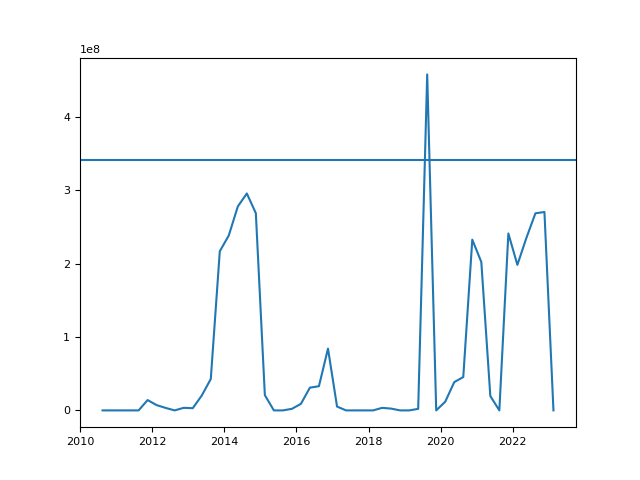

In [90]:
fig, ax = plt.subplots()
ax.axhline(lake_gdf.geometry.area.values[0])
ax.plot(df.midcyc_datetime, df['evolving_outlines_darea (m^2)'])

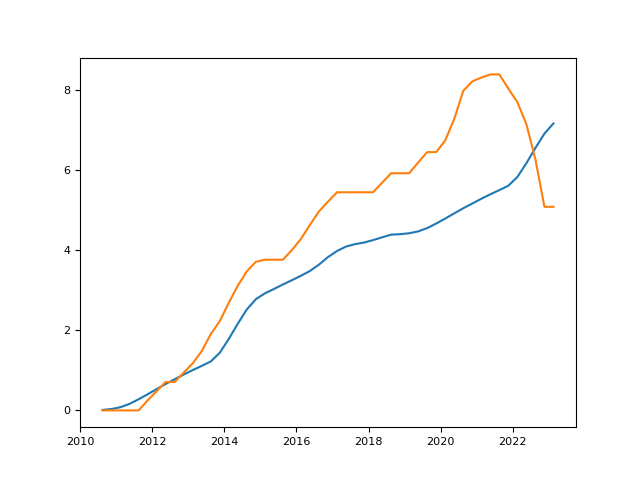

In [91]:
fig, ax = plt.subplots()
ax.plot(df.midcyc_datetime, np.cumsum(df['static_outline_dh (m)']))
ax.plot(df.midcyc_datetime, np.cumsum(df['evolving_outlines_dh (m)']))

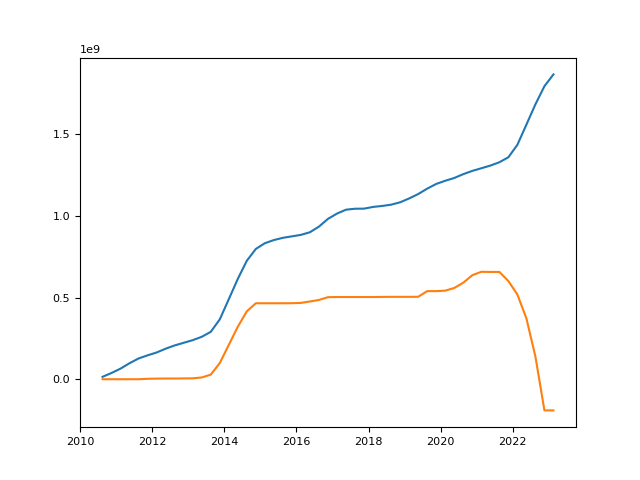

In [94]:
fig, ax = plt.subplots()
ax.plot(df.midcyc_datetime, np.cumsum(df['static_outline_dvol_corr (m^3)']))
ax.plot(df.midcyc_datetime, np.cumsum(df['evolving_outlines_dvol_corr (m^3)']))

In [ ]:
# Trying masking approach bc it is killing kernel

In [ ]:
# # hard coding compare_evolving_static_outlines function to debug

# # Isolate lake from Siegfried & Fricker, 2018 inventory as geodataframe using slicing
# idx = 46
# dataset1=CS2_Smith2017
# dataset2=ATL15_dh

# lake_gdf = lakes_gdf.iloc[idx:idx+1]

# # Define the evolving outlines file path and read in if it exists
# file_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0])
# if os.path.exists(file_path):  # Check if the file exists
#     outlines_gdf = gpd.read_file(file_path)
# # else:
# #     continue
    
# # Define lake name and polygon and buffered polygon to use as off-lake region
# lake_name = lake_gdf.name.values[0]
# static_outline = lake_gdf.iloc[0].geometry
# static_outline_buffered = muliple_area_buffer(static_outline, 2)
# evolving_outlines_unary_union = outlines_gdf.unary_union
# evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)

# # Combine static outline with evolving outlines from outlines_gdf
# combined_outline = unary_union([static_outline] + list(outlines_gdf.geometry))

# # Establish x_min, x_max, y_min, y_max from the combined outline
# x_min, y_min, x_max, y_max = combined_outline.bounds
# del combined_outline

# # Clipping datasets
# if dataset1 != 'none':
   
#     # Create and apply the mask to dataset variable
#     dataset1_combined_outline_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#     dataset1_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
#     dataset1_static_outline_mask_da = xr.DataArray(dataset1_static_outline_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
#     dataset1_static_outline_masked_data = dataset1['delta_h'].where(dataset1_static_outline_mask_da, drop=True)

#     dataset1_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
#     dataset1_static_region_mask = dataset1_static_outline_buffered_mask & ~dataset1_static_outline_mask
#     dataset1_static_region_mask_da = xr.DataArray(dataset1_static_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
#     dataset1_static_region_masked_data = dataset1['delta_h'].where(dataset1_static_region_mask_da, drop=True)

#     dataset1_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
#     dataset1_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
#     dataset1_evolving_outlines_region_mask = dataset1_evolving_outlines_unary_union_buffered_mask & ~dataset1_evolving_outlines_unary_union_mask
#     dataset1_evolving_outlines_region_mask_da = xr.DataArray(dataset1_evolving_outlines_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
#     dataset1_evolving_outlines_region_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_region_mask_da, drop=True)
    
# # Do same for dataset2
# dataset2_combined_outline_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
# dataset2_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
# dataset2_static_outline_mask_da = xr.DataArray(dataset2_static_outline_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
# dataset2_static_outline_masked_data = dataset1['delta_h'].where(dataset2_static_outline_mask_da, drop=True)

# dataset2_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
# dataset2_static_region_mask = dataset2_static_outline_buffered_mask & ~dataset2_static_outline_mask
# dataset2_static_region_mask_da = xr.DataArray(dataset1_static_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
# dataset2_static_region_masked_data = dataset1['delta_h'].where(dataset2_static_region_mask_da, drop=True)

# dataset2_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
# dataset2_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
# dataset2_evolving_outlines_region_mask = dataset2_evolving_outlines_unary_union_buffered_mask & ~dataset2_evolving_outlines_unary_union_mask
# dataset2_evolving_outlines_region_mask_da = xr.DataArray(dataset2_evolving_outlines_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
# dataset2_evolving_outlines_region_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_region_mask_da, drop=True)

# # Create empty list to store polygons, areas, perimeters and dates
# static_outline_dhs = []
# static_region_dhs = []
# static_outline_dhs_corr = []
# static_outline_dvols_corr = []
# evolving_outlines_dareas = []
# evolving_outlines_dhs = []
# evolving_region_dhs = []
# evolving_outlines_dhs_corr = []
# evolving_outlines_dvols_corr = []
# midcyc_datetimes = []

# # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
# for idx, dt in enumerate(cyc_dates['midcyc_dates']):
    
#     # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
#     # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
#     if idx <= 32:
#         if dataset1 != 'none':
#             dh_static_outline = dataset1_static_outline_masked_data[idx+1,:,:]-dataset1_static_outline_masked_data[idx,:,:]
#             dh_static_region = dataset1_static_region_masked_data[idx+1,:,:]-dataset1_static_region_masked_data[idx,:,:]

#             # Filter rows that match the current time slice
#             outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
            
#             # Check if outlines_gdf_dt_sub has any rows before proceeding
#             if not outlines_gdf_dt_sub.empty:
#                 outlines_gdf_dt_sub_unary_union = outlines_gdf_dt_sub.unary_union
#                 dataset1_evolving_outlines_dt_sub_mask = np.array([[outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
#                 dataset1_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset1_evolving_outlines_dt_sub_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
#                 dataset1_evolving_outlines_dt_sub_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_dt_sub_mask_da, drop=True)
#                 dh_evolving_outlines = dataset1_evolving_outlines_dt_sub_masked_data[idx+1,:,:]-dataset1_evolving_outlines_dt_sub_masked_data[idx,:,:]
#                 dh_evolving_outlines_region = dataset1_evolving_outlines_region_masked_data[idx+1,:,:]-dataset1_evolving_outlines_region_masked_data[idx,:,:]
#             elif outlines_gdf_dt_sub.empty:
#                 dh_evolving_outlines = 0
#                 dh_evolving_outlines_region = 0
#         else:
#             continue
#     # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
#     # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
#     elif idx > 32:
#         # Subtract 33 from idx to start over at index zero with new dataset
#         dh_static_outline = dataset2_static_outline_masked_data[(idx-33)+1,:,:]-dataset2_static_outline_masked_data[(idx-33),:,:]
#         dh_static_region = dataset2_static_region_masked_data[(idx-33)+1,:,:]-dataset2_static_region_masked_data[(idx-33),:,:]

#         # Filter rows that match the current time slice
#         outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
        
#         if not outlines_gdf_dt_sub.empty:
#             outlines_gdf_dt_sub_unary_union = outlines_gdf_dt_sub.unary_union
#             dataset2_evolving_outlines_dt_sub_mask = np.array([[outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
#             dataset2_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset2_evolving_outlines_dt_sub_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
#             dataset2_evolving_outlines_dt_sub_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_dt_sub_mask_da, drop=True)
#             dh_evolving_outlines = dataset2_evolving_outlines_dt_sub_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_dt_sub_masked_data[(idx-33),:,:]
#             dh_evolving_outlines_region = dataset2_evolving_outlines_region_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_region_masked_data[(idx-33),:,:]
#         elif outlines_gdf_dt_sub.empty:
#             dh_evolving_outlines = 0
#             dh_evolving_outlines_region = 0

#     # Store data into lists
#     static_outline_dh = np.nanmean(dh_static_outline)
#     static_region_dh = np.nanmean(dh_static_region)
#     static_outline_dh_corr = static_outline_dh - static_region_dh
#     static_outline_dvol_corr = static_outline_dh_corr*lake_gdf['area (m^2)'].values[0]

#     static_outline_dhs += [static_outline_dh]
#     static_region_dhs += [static_region_dh]
#     static_outline_dhs_corr += [static_outline_dh_corr]
#     static_outline_dvols_corr += [static_outline_dvol_corr]

#     outlines_gdf_dt_sub = outlines_gdf_dt_sub.to_crs('EPSG:4326')
#     evolving_outlines_darea = sum(outlines_gdf_dt_sub['geometry'].apply(    
#         lambda poly: abs(geod.polygon_area_perimeter(
#         poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None))

#     evolving_outlines_dh = np.nanmean(dh_evolving_outlines)
#     evolving_outlines_region_dh = np.nanmean(dh_evolving_outlines_region)
#     evolving_outlines_dh_corr = evolving_outlines_dh - evolving_region_dh
#     evolving_outlines_dvol_corr = evolving_outlines_dh_corr*evolving_outlines_darea

#     evolving_outlines_dareas += [evolving_outlines_darea]
#     evolving_outlines_dhs += [evolving_outlines_dh]
#     evolving_outlines_region_dhs += [evolving_outlines_region_dh]
#     evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
#     evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

#     midcyc_datetimes += [midcyc_dates[idx]]

#     # Clear the output of each index
#     clear_output(wait=True)
    
# # Store polygons in dataframe for further analysis
# d = {'midcyc_datetime': midcyc_datetimes,
#      'evolving_outlines_darea (m^2)': evolving_outlines_dareas,
#      'evolving_outlines_dh (m)': evolving_outlines_dhs,
#      'evolving_region_dh (m)': evolving_region_dhs,
#      'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
#      'evolving_outlines_dvol_corr (m^3)': evolving_outlines_dvols_corr,
#      'static_outline_dh (m)': static_outline_dhs, 
#      'static_region_dh (m)': static_region_dhs,
#      'static_outline_dh_corr (m)': static_outline_dhs_corr,
#      'static_outline_dvol_corr (m^3)': static_outline_dvols_corr}
# df = pd.DataFrame(d)

# # Export dataframe to csv
# df.to_csv('output/lake_outlines/compare_evolving_static_outlines/{}.csv'.format(lake_name), index=False)
# df

In [113]:
# hard coding compare_evolving_static_outlines function to debug

# Isolate lake from Siegfried & Fricker, 2018 inventory as geodataframe using slicing
idx = 2  
    
# Assign dataset; during CS2 era, assign based on SARIn coverage time period
if lakes_gdf['CS2_SARIn_time_period'][idx] == 'nan':
    dataset1='none'
elif lakes_gdf['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
    dataset1=CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
elif lakes_gdf['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
    dataset1=CS2_Smith2017
dataset2=ATL15_dh

lake_gdf = lakes_gdf.iloc[idx:idx+1]

# Define the evolving outlines file path and read in if it exists
file_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0])
if os.path.exists(file_path):  # Check if the file exists
    outlines_gdf = gpd.read_file(file_path)
# else:
#     continue
    
# Define lake name and polygon and buffered polygon to use as off-lake region
lake_name = lake_gdf.name.values[0]
static_outline = lake_gdf.iloc[0].geometry
static_outline_buffered = muliple_area_buffer(static_outline, 2)
evolving_outlines_unary_union = outlines_gdf.unary_union
evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)

# Combine static outline with evolving outlines from outlines_gdf
combined_outline = unary_union([static_outline] + list(outlines_gdf.geometry))

# Establish x_min, x_max, y_min, y_max from the combined outline
x_min, y_min, x_max, y_max = combined_outline.bounds
del combined_outline

# Clipping datasets
if dataset1 != 'none':

    # Create and apply the mask to dataset variable
    dataset1_combined_outline_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset1_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
    dataset1_static_outline_mask_da = xr.DataArray(dataset1_static_outline_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
    dataset1_static_outline_masked_data = dataset1['delta_h'].where(dataset1_static_outline_mask_da, drop=True)

    dataset1_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
    dataset1_static_region_mask = dataset1_static_outline_buffered_mask & ~dataset1_static_outline_mask
    dataset1_static_region_mask_da = xr.DataArray(dataset1_static_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
    dataset1_static_region_masked_data = dataset1['delta_h'].where(dataset1_static_region_mask_da, drop=True)

    dataset1_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
    dataset1_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
    dataset1_evolving_outlines_region_mask = dataset1_evolving_outlines_unary_union_buffered_mask & ~dataset1_evolving_outlines_unary_union_mask
    dataset1_evolving_outlines_region_mask_da = xr.DataArray(dataset1_evolving_outlines_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
    dataset1_evolving_outlines_region_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_region_mask_da, drop=True)

# Do same for dataset2
dataset2_combined_outline_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
dataset2_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
dataset2_static_outline_mask_da = xr.DataArray(dataset2_static_outline_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
dataset2_static_outline_masked_data = dataset2['delta_h'].where(dataset2_static_outline_mask_da, drop=True)

dataset2_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
dataset2_static_region_mask = dataset2_static_outline_buffered_mask & ~dataset2_static_outline_mask
dataset2_static_region_mask_da = xr.DataArray(dataset2_static_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
dataset2_static_region_masked_data = dataset2['delta_h'].where(dataset2_static_region_mask_da, drop=True)

dataset2_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
dataset2_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
dataset2_evolving_outlines_region_mask = dataset2_evolving_outlines_unary_union_buffered_mask & ~dataset2_evolving_outlines_unary_union_mask
dataset2_evolving_outlines_region_mask_da = xr.DataArray(dataset2_evolving_outlines_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
dataset2_evolving_outlines_region_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_region_mask_da, drop=True)

# Create empty list to store polygons, areas, perimeters and dates
static_outline_dhs = []
static_region_dhs = []
static_outline_dhs_corr = []
static_outline_dvols_corr = []
evolving_outlines_dareas = []
evolving_outlines_dhs = []
evolving_outlines_region_dhs = []
evolving_outlines_dhs_corr = []
evolving_outlines_dvols_corr = []
midcyc_datetimes = []

# Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
for idx, dt in enumerate(cyc_dates['midcyc_dates']):

    # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
    # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
    if idx <= 32:
        if dataset1 != 'none':
            static_outline_dh = dataset1_static_outline_masked_data[idx+1,:,:]-dataset1_static_outline_masked_data[idx,:,:]
            static_outline_region_dh = dataset1_static_region_masked_data[idx+1,:,:]-dataset1_static_region_masked_data[idx,:,:]

            # Filter rows that match the current time slice
            outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]

            # Check if outlines_gdf_dt_sub has any rows before proceeding
            if not outlines_gdf_dt_sub.empty:
                outlines_gdf_dt_sub_unary_union = outlines_gdf_dt_sub.unary_union
                dataset1_evolving_outlines_dt_sub_mask = np.array([[outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
                dataset1_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset1_evolving_outlines_dt_sub_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
                dataset1_evolving_outlines_dt_sub_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_dt_sub_mask_da, drop=True)
                evolving_outlines_dh = dataset1_evolving_outlines_dt_sub_masked_data[idx+1,:,:]-dataset1_evolving_outlines_dt_sub_masked_data[idx,:,:]
                evolving_outlines_region_dh = dataset1_evolving_outlines_region_masked_data[idx+1,:,:]-dataset1_evolving_outlines_region_masked_data[idx,:,:]
            elif outlines_gdf_dt_sub.empty:
                evolving_outlines_dh = 0
                evolving_outlines_region_dh = 0
        else:
            continue
    # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
    # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
    elif idx > 32:
        # Subtract 33 from idx to start over at index zero with new dataset
        static_outline_dh = dataset2_static_outline_masked_data[(idx-33)+1,:,:]-dataset2_static_outline_masked_data[(idx-33),:,:]
        static_outline_region_dh = dataset2_static_region_masked_data[(idx-33)+1,:,:]-dataset2_static_region_masked_data[(idx-33),:,:]

        # Filter rows that match the current time slice
        outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]

        if not outlines_gdf_dt_sub.empty:
            outlines_gdf_dt_sub_unary_union = outlines_gdf_dt_sub.unary_union
            dataset2_evolving_outlines_dt_sub_mask = np.array([[outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
            dataset2_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset2_evolving_outlines_dt_sub_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
            dataset2_evolving_outlines_dt_sub_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_dt_sub_mask_da, drop=True)
            evolving_outlines_dh = dataset2_evolving_outlines_dt_sub_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_dt_sub_masked_data[(idx-33),:,:]
            evolving_outlines_region_dh = dataset2_evolving_outlines_region_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_region_masked_data[(idx-33),:,:]
        elif outlines_gdf_dt_sub.empty:
            evolving_outlines_dh = 0
            evolving_outlines_region_dh = 0

    # Store data into lists
    static_outline_dh_mean = np.nanmean(static_outline_dh)
    static_outline_region_dh_mean = np.nanmean(static_outline_region_dh)
    static_outline_dh_corr = static_outline_dh_mean - static_outline_region_dh_mean
    static_outline_dvol_corr = static_outline_dh_corr*lake_gdf['area (m^2)'].values[0]

    static_outline_dhs += [static_outline_dh_mean]
    static_region_dhs += [static_outline_region_dh_mean]
    static_outline_dhs_corr += [static_outline_dh_corr]
    static_outline_dvols_corr += [static_outline_dvol_corr]

    outlines_gdf_dt_sub = outlines_gdf_dt_sub.to_crs('EPSG:4326')
    evolving_outlines_darea = sum(outlines_gdf_dt_sub['geometry'].apply(    
        lambda poly: abs(geod.polygon_area_perimeter(
        poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None))

    evolving_outlines_dh_mean = np.nanmean(evolving_outlines_dh)
    evolving_outlines_region_dh_mean = np.nanmean(evolving_outlines_region_dh)
    evolving_outlines_dh_corr = evolving_outlines_dh_mean - evolving_outlines_region_dh_mean
    evolving_outlines_dvol_corr = evolving_outlines_dh_corr*evolving_outlines_darea

    evolving_outlines_dareas += [evolving_outlines_darea]
    evolving_outlines_dhs += [evolving_outlines_dh_mean]
    evolving_outlines_region_dhs += [evolving_outlines_region_dh_mean]
    evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
    evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

    midcyc_datetimes += [midcyc_dates[idx]]

    # Clear the output of each index
    clear_output(wait=True)

# Store polygons in dataframe for further analysis
d = {'midcyc_datetime': midcyc_datetimes,
     'evolving_outlines_darea (m^2)': evolving_outlines_dareas,
     'evolving_outlines_dh (m)': evolving_outlines_dhs,
     'evolving_region_dh (m)': evolving_outlines_region_dhs,
     'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
     'evolving_outlines_dvol_corr (m^3)': evolving_outlines_dvols_corr,
     'static_outline_dh (m)': static_outline_dhs, 
     'static_region_dh (m)': static_region_dhs,
     'static_outline_dh_corr (m)': static_outline_dhs_corr,
     'static_outline_dvol_corr (m^3)': static_outline_dvols_corr}
df = pd.DataFrame(d)

# Export dataframe to csv
df.to_csv('output/lake_outlines/compare_evolving_static_outlines/{}.csv'.format(lake_name), index=False)

df

,midcyc_datetime,evolving_outlines_darea (m^2),evolving_outlines_dh (m),evolving_region_dh (m),evolving_outlines_dh_corr (m),evolving_outlines_dvol_corr (m^3),static_outline_dh (m),static_region_dh (m),static_outline_dh_corr (m),static_outline_dvol_corr (m^3)
0,2018-11-16 14:15:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-0.061704,-0.053541,-0.008162,-1.146451e+06
1,2019-02-15 21:45:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.045116,0.038787,0.006329,8.889169e+05
2,2019-05-18 05:15:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-0.056321,-0.063888,0.007567,1.062898e+06
3,2019-08-17 12:45:00,2.354254e+07,0.169561,0.081069,0.088492,2.083320e+06,0.078042,0.093754,-0.015712,-2.206811e+06
4,2019-11-16 20:15:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-0.043499,-0.045954,0.002455,3.448338e+05
5,2020-02-16 03:45:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.025746,0.023289,0.002457,3.450541e+05
6,2020-05-17 11:15:00,3.724204e+07,0.166412,0.111526,0.054886,2.044079e+06,0.085817,0.112397,-0.026581,-3.733392e+06
7,2020-08-16 18:45:00,6.635735e+06,-0.148214,-0.030245,-0.117969,-7.828106e+05,-0.014138,-0.036501,0.022363,3.141039e+06
8,2020-11-16 02:15:00,1.222498e+06,-0.149963,-0.050987,-0.098976,-1.209979e+05,-0.057455,-0.053731,-0.003724,-5.230348e+05
9,2021-02-15 09:45:00,5.058147e+06,-0.179932,-0.064501,-0.115430,-5.838641e+05,-0.061506,-0.076342,0.014836,2.083838e+06


In [110]:
type(lakes_gdf['CS2_SARIn_time_period'][2])

str

In [103]:
combined_outline = unary_union([static_outline] + list(outlines_gdf.geometry))
# gpd.GeoDataFrame(geometry=[combined_outline]).plot()
x_min, y_min, x_max, y_max = combined_outline.bounds
print(x_min, y_min, x_max, y_max)

-879881.998107 -657729.8247576479 -862471.7128184242 -642297.0279325811


# Fig. S1

In [ ]:
ROI_poly = buffered_poly
print(type(buffered_poly))
print(type(ROI_poly))

In [ ]:
ROI_poly = buffered_poly
dataset1 = CS2_dh
dataset2 = ATL15_dh

# Clipping datasets
dataset1_clipped = dataset1.rio.clip(ROI_poly, dataset1.rio.crs)
dataset2_clipped = dataset2.rio.clip(ROI_poly, dataset2.rio.crs)

# Extract min and max of x and y for dataset1
min_x1 = dataset1_clipped.x.min().item()
max_x1 = dataset1_clipped.x.max().item()
min_y1 = dataset1_clipped.y.min().item()
max_y1 = dataset1_clipped.y.max().item()

# Extract min and max of x and y for dataset2
min_x2 = dataset2_clipped.x.min().item()
max_x2 = dataset2_clipped.x.max().item()
min_y2 = dataset2_clipped.y.min().item()
max_y2 = dataset2_clipped.y.max().item()

# Check if the coordinates match
if min_x1 != min_x2 or max_x1 != max_x2 or min_y1 != min_y2 or max_y1 != max_y2:
    raise ValueError("Dataset1 and Dataset2 do not have matching x, y min, max coordinates")

# Establish x_min, x_max, y_min, y_max, 
x_min = min_x1
x_max = max_x1
y_min = min_y1
y_max = max_y1

# Subsetting datasets
# Subset datasets to region of interest for plotting
buffer = 4000
mask_x = (dataset1.x >= x_min-buffer) & (dataset1.x <= x_max+buffer)
mask_y = (dataset1.y >= y_min-buffer) & (dataset1.y <= y_max+buffer)
dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
mask_x = (dataset2.x >= x_min-buffer) & (dataset2.x <= x_max+buffer)
mask_y = (dataset2.y >= y_min-buffer) & (dataset2.y <= y_max+buffer)
dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
mask_x = (moa_highres_da.x >= x_min-buffer) & (moa_highres_da.x <= x_max+buffer)
mask_y = (moa_highres_da.y >= y_min-buffer) & (moa_highres_da.y <= y_max+buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)

In [ ]:
# Modify find contours function to achieve something like less than 5% of contours intersecting with buffer
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
gdf = find_evolving_outlines('Slessor_2_3_23', buffered_poly, 0.5, CS2_dh, ATL15_dh)

In [ ]:
# TODO
# Try other lakes

# Plot Fig. 2
fig, ax = plt.subplots(3,1, sharex=True, figsize=(5.5,16.5))


# Panel A - Plot uplift filling event
# Specify the time value you want to plot
specified_date = datetime.date(2010, 8, 17)
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[0], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[0], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.cyc_to_cyc_delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.cyc_to_cyc_delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
divnorm=colors.TwoSlopeNorm(vmin=-1.5, vcenter=0., vmax=1.5)  
img = ax[0].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='upper', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)

# Plot buffered polygon showing extent of evolving outline search
ROI_color = 'magenta'
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[0], color=ROI_color)

# Create an axes on the right side of ax1 for the colorbar
cax = fig.add_axes([ax[0].get_position().x1 + 0.15, ax[0].get_position().y0 - 0.092, 0.03, ax[0].get_position().height])
fig.colorbar(img, cax=cax).set_label('height change [m]', size=12)

# Annotate time slice
ax[0].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel B - Plot subsidence draining event
# specified_date = datetime.date(2021, 2, 15)
specified_date = datetime.date(2020, 2, 16)
# specified_date = datetime.date(2015, 8, 17)

gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[1], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[1], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.delta_h[nearest_time_index+1,:,:]-dataset1_subset.delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.delta_h[(nearest_time_index-33)+1,:,:]-dataset2_subset.delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
img = ax[1].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='lower', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[1], color=ROI_color)

ax[1].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel C - Plot outlines in aggregate vs. two past static delineations
# Plot MOA imagery  
ax[2].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(midcyc_dates)-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(midcyc_dates[0]), 
                     mdates.date2num(midcyc_dates[-1]))

# Use for loop to store each time slice as line segment to use in legend
# And plot each outline in the geopandas dataframe and color by date
lines = []  # list of lines to be used for the legend
for idx, dt in enumerate(midcyc_dates, 0):
    x = 1; y = 1
    line, = ax[2].plot(x, y, color=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), linewidth=3)
    lines.append(line)
    
    # Filter rows that match the current time slice
    gdf_subset_dt = gdf_subset[gdf_subset['datetime'] == dt]

    # Plotting the subset
    gdf_subset_dt.plot(ax=ax[2], edgecolor=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), facecolor='none')

    
# All panels
# Label axes
ax[2].set_xlabel('x [km]', size=16)
ax[1].set_ylabel('y [km]', size=16)

# ax[0].annotate('A', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[1].annotate('B', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[2].annotate('C', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
ax[0].annotate('A', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[1].annotate('B', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[2].annotate('C', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)

# Create lines for legend
S09_color = 'lightseagreen'
SF18_color = 'teal'
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 2)), linewidth=3)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
ROI = plt.Line2D((0, 1), (0, 0), color=ROI_color, linestyle='solid', linewidth=3)
uplift = plt.Line2D((0, 1), (0, 0), color='blue', linewidth=3)
subsidence = plt.Line2D((0, 1), (0, 0), color='red', linewidth=3)

# Create legends
ax[0].legend([Smith2009, SiegfriedFricker2018, ROI, uplift], 
           ['static outline [10]',
            'static outline [13]', 
            # 'evolving outline ({} m threshold)'.format(threshold)], 
            'evolving outline search limit [this study]',
            'evolving outline - uplift [this study]'], 
             loc='upper right') 

ax[1].legend([subsidence],
           ['evolving outline - subsidence [this study]'], 
             loc='upper right')

legend = ax[2].legend([tuple(lines)], ['evolving outlines [this study]'],
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper center')
legend.get_frame().set_linewidth(0.0)
ax[2].patch.set_alpha(1)

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=discrete_cmap)
m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:]]))
cax = inset_axes(ax[2],
                 width="100%",
                 height="2.5%",
                 loc=3,
                 bbox_to_anchor=[0,-0.14,1,1],
                 bbox_transform=ax[2].transAxes,
                 borderpad=0,
                 )
cbar=fig.colorbar(m, ticks=np.array([2010,2012,2014,2016,2018,2020,2022]), 
             cax=cax, orientation='horizontal').set_label('evolving outline year', size=15)

# Plot inset map
axIns = ax[0].inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
axIns.axis('off')
# # Plot black rectangle to indicate location
# rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
# axIns.add_artist(rect)
# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

# # Add annotation to the opposite side of the colorbar
# cbar.ax.text(1.1, 0.5, 'CryoSat-2 era', va='center', ha='left', transform=cbar.ax.transAxes)

for i in ax: 
    S09_outlines.boundary.plot(ax=i, edgecolor=S09_color, facecolor='none', linestyle=(0, (1, 2)), linewidth=3, alpha=1, zorder=0)
    SF18_outlines.boundary.plot(ax=i, edgecolor=SF18_color, facecolor='none', linestyle=(0, (1, 1)), linewidth=3, alpha=1, zorder=0)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.yaxis.set_major_formatter(ticks_y)
    
    # i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   
    i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   

plt.tight_layout()

plt.show()

In [ ]:
# I can't figure out why data_counts plot looks sparse when you plot at continental scale
plt.close()
for idx in range(145, len(lakes_gdf)):

    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry

    # # Create buffered polygons for various multiples of lake area to find which
    # # best emcompasses the height change signals at previously identified lakes
    buffered_poly_2x = muliple_area_buffer(lake_poly, 2)
    # buffered_poly_3x = muliple_area_buffer(lake_poly, 3)
    # buffered_poly_4x = muliple_area_buffer(lake_poly, 4)
    # buffered_poly_5x = muliple_area_buffer(lake_poly, 5)

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_poly_2x.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*10
    y_buffer = abs(y_max-y_min)*10

    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)

    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_data_counts'))
    create_folder(OUTPUT_DIR + '/plot_data_counts/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    lakes_gdf_notSF18_color = 'deepskyblue'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_gdf_notSF18 = plt.Line2D((0, 1), (0, 0), color=lakes_gdf_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(33,34):#len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            count_subset = dataset1_subset['data_count'][idx,:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            count_subset = dataset2_subset['data_count'][(idx-33),:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        # if np.any(~np.isnan(count_subset)):
        # Create fig, ax
        fig, ax = plt.subplots()

        # Plot figure
        img = ax.imshow(count_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
            origin='lower', cmap='viridis')

        buffered_poly_2x.boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=5)

In [ ]:
# Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
# Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
# if np.any(~np.isnan(count_subset)):
plt.close()
# Create fig, ax
fig, ax = plt.subplots()

idx=44

# Plot figure
img = ax.imshow(dataset2['data_count'][(idx-33),:,:], 
    # extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer],
    extent=[dataset2.x.min(), dataset2.x.max(), dataset2.y.min(), dataset2.y.max()], 
    origin='lower', 
    # cmap='viridis'
    )

buffered_poly_2x.boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=5)
plt.show()
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('data counts', size=15)

plt.show()